# Sequential SAR Change Detection

In [ ]:
import ee
ee.Authenticate()

In [1]:
%matplotlib inline
from auxil.eeSar_seq import run
run()

Map(center=[51.0, 6.4], controls=(MeasureControl(options=['active_color', 'capture_z_index', 'completed_color'…

# How to use the interface

#### To generate change maps:

    - Select the desired time interval
    - Use the Polygon or rectangle tool to select an ROI (default: Jülich, Germany and surroundings). Multiple polygons are accepted. Navigate  to different parts of the world with the GoTo button
    - Leave the relative orbit value at 0
    - Choose orbit pass (ascending or descending), platform (A, B or Both)
    - Choose change map type for previewing (color-coded time of first change, last change or change frequency) or a bitemporal map for any of the consecutive time intervals
    - Set a desired opacity for the preview overlay
    - Leave the significance level at its default value
    - Select or deselect whether to show initially a minimum cloud cover S2 image. If deselected, a temporal average of all S1 images found is displayed
    - Press Collect to accumulate the images
Information about the images found is shown in the output window and an S2 image or a composite of the mean of all of the images is overlayed onto the map. If more than one relative orbit number is present, you can choose one of them by entering its value into the mask. For change detection, it is advisable not to use more than one orbit. 

    - Press Collect again if desired
    - Press Preview to see a preview overlay of the chosen change map 
Depending on the size of the images and their number, this can take up to a few minutes. The overlay is built up tile-by-tile as the GEE servers complete their tasks. Selecting a different change map or opacity does not require a new Run: the Preview button remains activated. You can use a water mask and/or make the no change pixels transparent with the corresponding check boxes. The color coding of the change maps is explained in the output window. When satisfied, enter username/path in the Export to assets mask or the filename in the export to drive mask. 
    
    - Select ExportToAssets or ExportToDrive to start an export task on the GEE servers
An additional metadata file in CSV format is exported to the Google Drive for each asset/drive export. 

    - Select ExporSeries to export the entire time series
This triggers an export of the entire S1 time series subsets as well as the S2 image (if selected) to the Google Drive.

    - Select ExportATSF to export a temporal filter of the last image in the time series
The exported image contains the mean value of every pixel from the time of the most recent significant change.    

    - Select GetPolyFromAsset
To return to a previously examined location.

    - Select PlotFromAsset
To generate change plots from any asset previously exported from the application. The graphs are discrimiated by Loewner order (positive definite, negative definite or indefinite) are saved in the home directory under the name of the asset itself. 

    - Select ClearPoly
To erase all existing polygons.    

    - Select EstimateENL
To calculate the ENL in the current polygon. The region chosen should be small (not larger than abou 50ha) to avoid timeouts.    

#### Other platforms

You can also analyse your own image collection, if available (e.g. fully dual pol sentinel-1 images downloaded from RSA and pre-processed wth the SNAP toolbox, or preprocessed RadarSat-2 imagery). Enter the collection name in the input template and the corresponding ENL. In order to enable the Collect button, draw an arbitrary polygon on the map.

#### File structure

The exported or downloaded, per-pixel change maps for a time sequence of length k are combined into a single file in GeoTiff format:

    band 1 cmap: Period in which most recent significant change occured (integer 1 ... k-1)
    band 2 smap: Period in which the first significant change occurred (integer 1 ... k-1)
    bans 3 fmap: Number of significant changes (integer 1 ... k-1)
    bands 4 ... k+3: Changes in each interval (1=positive definite, 2=negative definite, 3=indefinite)
    band k+4: Sentinel 2 background image (band B8) if available, otherwise averaged VV band of the s1 series. (This is only appended on export to assets)
    
#### Fine adjustments

    - Select a different significance level
The significance level applies to the tests performed in each change interval. They are statistically independent for no-change observations. 

    -Select 3x3 median filter
The p-values used in the tests are filtered before testing. This has the effect of supressing single-pixel changes (salt-and-pepper effect).

    -Select Quick Preview
Preview results are calculated at the scale corresponding to the current zoom level. This invalidates the ENL value so that, in general, fewer changes are detected. However calculation time is shortened, which is conveneient for rough data exploration. Unselect in order to force calcuation at the nominal scale of the data. 

    -Select a stride
Analyse only a subset of the available images. Stride = 2 for every second image, = 3 for every third, etc. Changing the stride requires that Collect be repeated.

#### Limits

The ROI should be completely enclosed within the S1 full scenes involved in the calculation. The larger the ROI and the longer the time series, the longer the preview and export calculations. By experience, time series longer than about 75 will cause a GEE server internal error (due to stack overflow caused by the depth of iteration).

#### References 

Knut Conradsen, Allan Aasbjerg Nielsen and Henning Skriver (2016). Determining the points of change in time series of polarimetric SAR data. IEEE Transactions on Geoscience and Remote Sensing 54(5), 3007-3024 http://www2.imm.dtu.dk/pubdb/views/publication_details.php?id=6825

Morton Canty, Allan Aasbjeg Nielsen, Henning Skriver and Knut Conradsen (2019). Statistical Analysis of Changes in Sentinel-1 Time Series on the Google Earth Engine, Remote Sensing 12(46), 1-16 https://www.mdpi.com/2072-4292/12/1/46



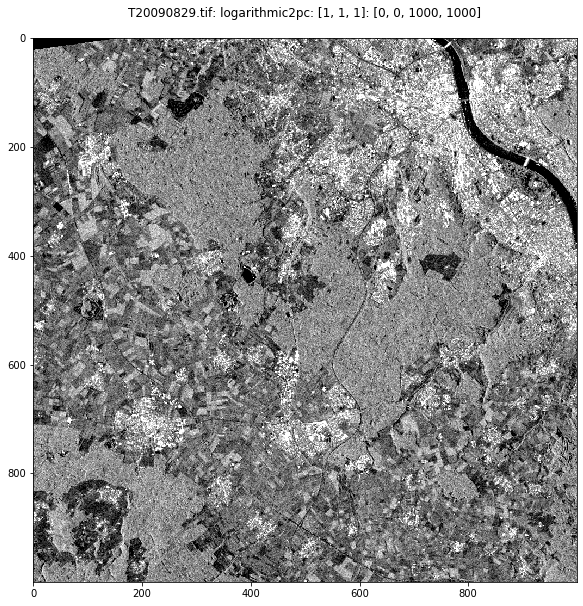

In [5]:
%run scripts/dispms -f imagery/radarsat2bonn/T20090829.tif

     ENL Estimation
Thu Aug 13 13:08:08 2020
infile:  imagery/radarsat2bonn/T20090829.tif
Quad polarimetry
filtering...
row: 100 200 
Mode: 12.285000


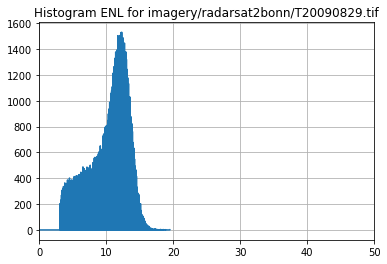

elapsed time: 11.781148910522461


In [7]:
%run auxil/enlml -d [500,400,300,300] imagery/radarsat2bonn/T20090829.tif

In [3]:
import numpy as np
from osgeo import gdal
from osgeo.gdalconst import GDT_Float32,GA_ReadOnly

# get a RS2 image
inDataset = gdal.Open('imagery/radarsat2bonn/T20100426.tif',GA_ReadOnly)
cols = inDataset.RasterXSize
rows = inDataset.RasterYSize    
# simulate complex Wishart pixels for quad pol, ENL = 12
m = 12
simimage = np.zeros((cols*rows,9))
for i in range(cols*rows):
    if i % 50000 == 0:
        print (i,end=' ')
    X = np.mat(np.random.randn(m,3))
    Y = np.mat(np.random.randn(m,3))
    Wr = X.T*X + Y.T*Y
    Wi = X.T*Y - Y.T*X
    W = (Wr - 1j*Wi)/2
    simimage[i,0] = np.real(W[0,0])
    simimage[i,1] = np.real(W[0,1])
    simimage[i,2] = np.imag(W[0,1])
    simimage[i,3] = np.real(W[0,2])
    simimage[i,4] = np.imag(W[0,2])
    simimage[i,5] = np.real(W[1,1])
    simimage[i,6] = np.real(W[1,2])
    simimage[i,7] = np.imag(W[1,2])
    simimage[i,8] = np.real(W[2,2])
# write simulated image to same projection as RS2 image          
driver = gdal.GetDriverByName('GTiff')    
outDataset = driver.Create('imagery/enlsim.tif',cols,rows,9,GDT_Float32) 
projection = inDataset.GetProjection()
geotransform = inDataset.GetGeoTransform()
if geotransform is not None:
    outDataset.SetGeoTransform(geotransform)
if projection is not None:
    outDataset.SetProjection(projection)
for i in range(9):
    outBand = outDataset.GetRasterBand(i+1)
    outBand.WriteArray(np.reshape(simimage[:,i],(rows,cols)),0,0) 
    outBand.FlushCache()  
outDataset = None    
print('Done')

0 50000 100000 150000 200000 250000 300000 350000 400000 450000 500000 550000 600000 650000 700000 750000 800000 850000 900000 950000 Done


     ENL Estimation
Thu Aug 13 17:13:07 2020
infile:  imagery/enlsim.tif
Quad polarimetry
filtering...
row: 100 200 300 400 
Mode: 12.193500


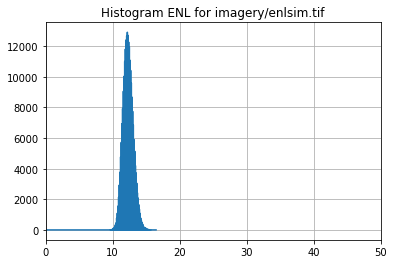

elapsed time: 31.772964239120483


<Figure size 432x288 with 0 Axes>

In [4]:
%run auxil/enlml -d [100,100,500,500] imagery/enlsim.tif

     ENL Estimation
Thu Aug 13 15:34:25 2020
infile:  imagery/s1test.tif
Diagonal-only polarimetry, using first band only
filtering...
row: 100 
Mode: 5.796900


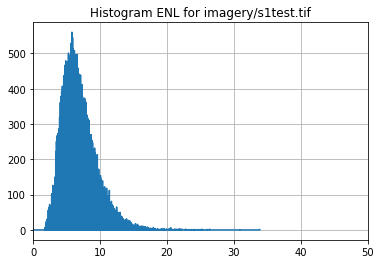

elapsed time: 2.039379596710205


In [3]:
%run auxil/enlml  imagery/s1test.tif